In [7]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [8]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [9]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [10]:
def _classify_volume_states(df, window=20):
    df = df.copy()
    df['time_group'] = df.index.time
    
    # 计算滚动统计量（保持原始时间索引）
    vol_stats = df.groupby('time_group')['volume'].rolling(window, min_periods=10).agg(['mean', 'std'])
    
    # 修复点：正确处理多级索引 -> 使用索引名而非固定列名
    vol_stats = vol_stats.reset_index(level=0, drop=True)  # 丢弃time_group索引层
    vol_stats.index.name = None  # 清除索引名避免冲突
    
    # 合并统计量回原始DF
    df = df.join(vol_stats, rsuffix='_stat')
    
    # 计算喷发阈值
    df['eruption_threshold'] = df['mean'] + df['std']
    df['is_eruption'] = df['volume'] > df['eruption_threshold']
    
    # --- 核心修改处 ---
    # 在 shift() 操作后，使用 .fillna(False) 将 NaN 值替换为 False
    # 这可以防止类型错误，并确保后续的布尔运算能够正确执行
    df['prev_eruption'] = df['is_eruption'].shift(1).fillna(False)
    df['next_eruption'] = df['is_eruption'].shift(-1).fillna(False)
    # --- 修改结束 ---
    
    df['is_peak'] = df['is_eruption'] & (~df['prev_eruption']) & (~df['next_eruption'])
    df['is_ridge'] = df['is_eruption'] & ~df['is_peak']
    df['is_valley'] = ~df['is_eruption']
    
    # 清理中间列（添加新增的统计列）
    df.drop(['mean', 'std', 'eruption_threshold', 'is_eruption', 
             'prev_eruption', 'next_eruption'], axis=1, inplace=True)
    
    return df

# 因子1: 分钟数因子（量峰、量岭）

In [11]:
def factor_minute_count(df, state='peak', lookback=96):
    """
    统计过去24小时（96根K线）内特定状态出现的次数
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    lookback: 回看窗口大小（24小时=96根15分钟K线）
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 滚动统计状态出现次数
    factor_vals = df[state_col].rolling(window=lookback, min_periods=24).sum()
    
    # 标准化处理
    return factor_vals / lookback

因子测试框架 - 量峰分钟数因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006963
   Rank_IC (Spearman): 0.009790
📊 信息比率:
   IR: nan
   有效分组数: 8
📊 因子分布:
📋 数据概况:
   数据长度: 132183
   因子列: factor_minute_count
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


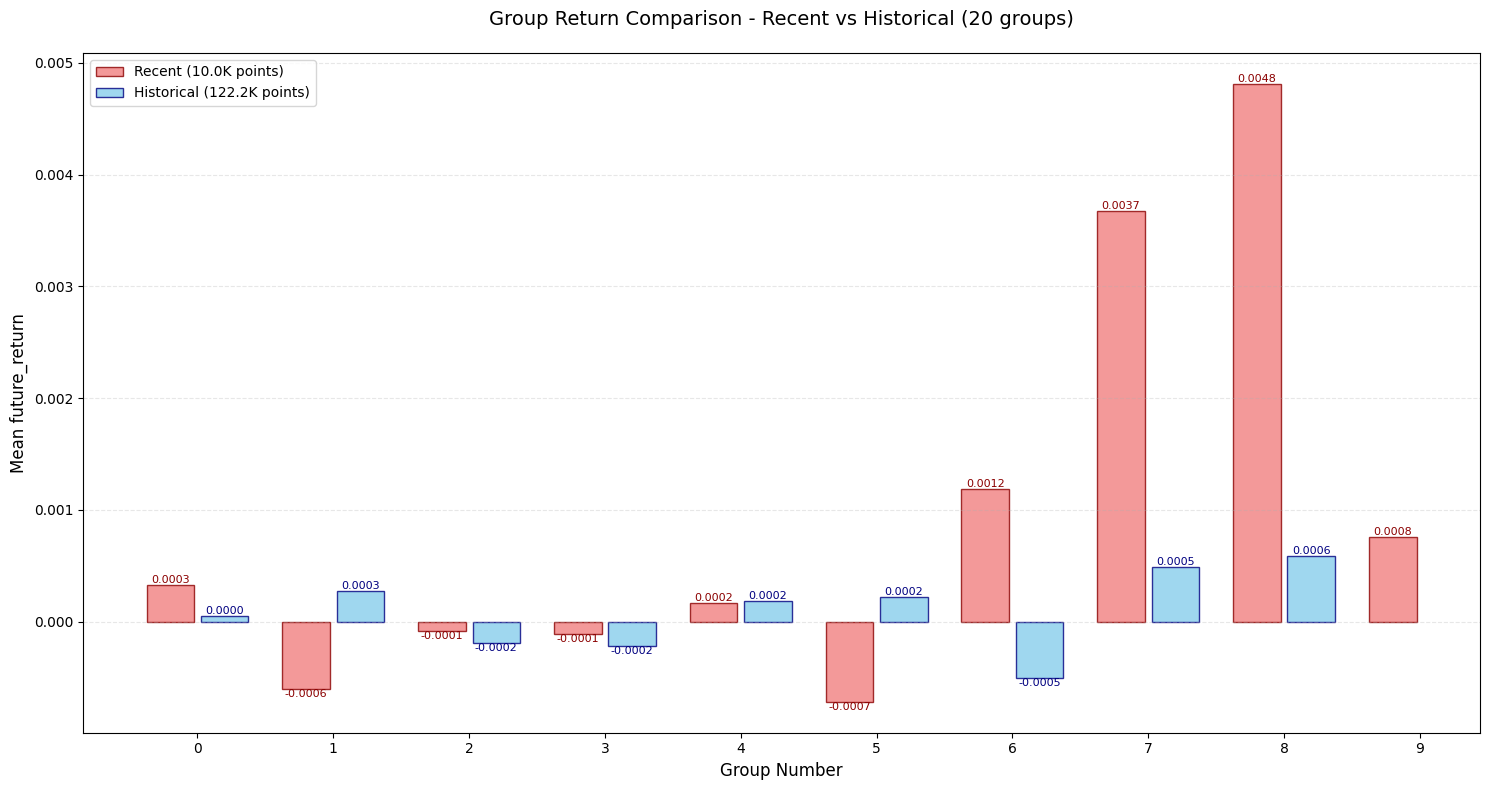

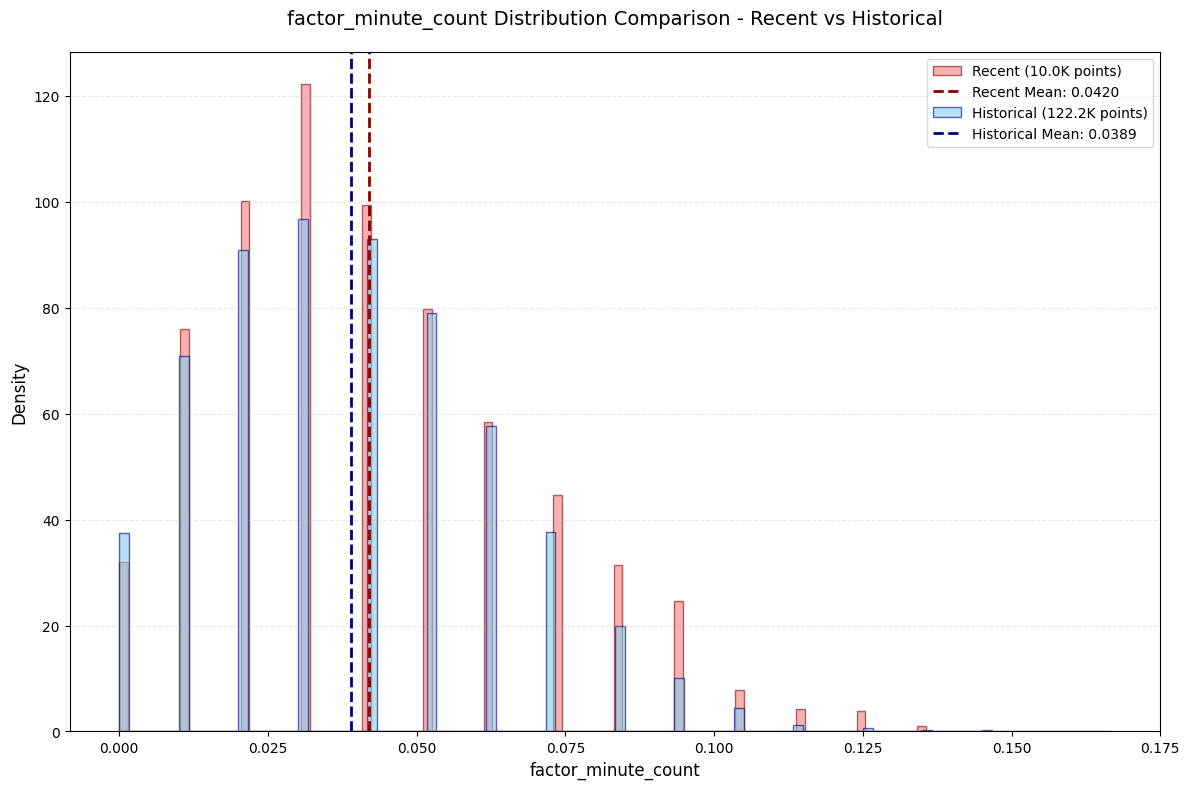

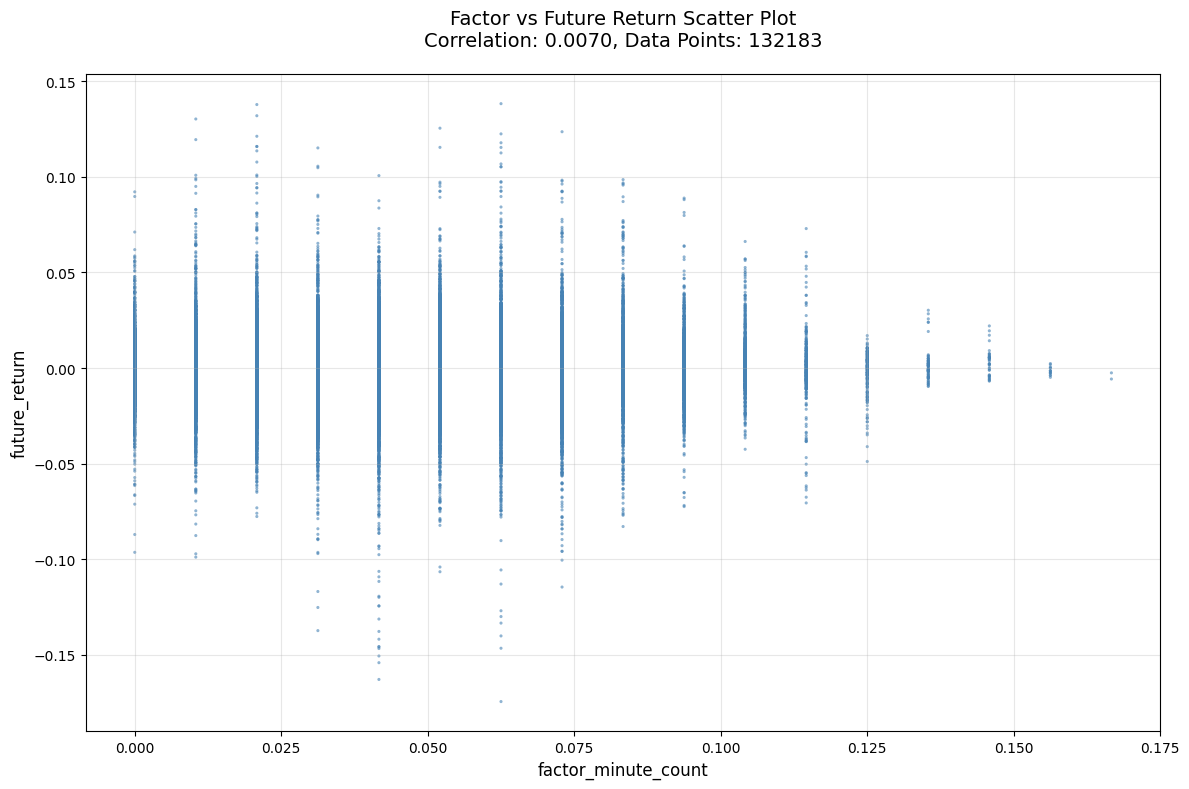

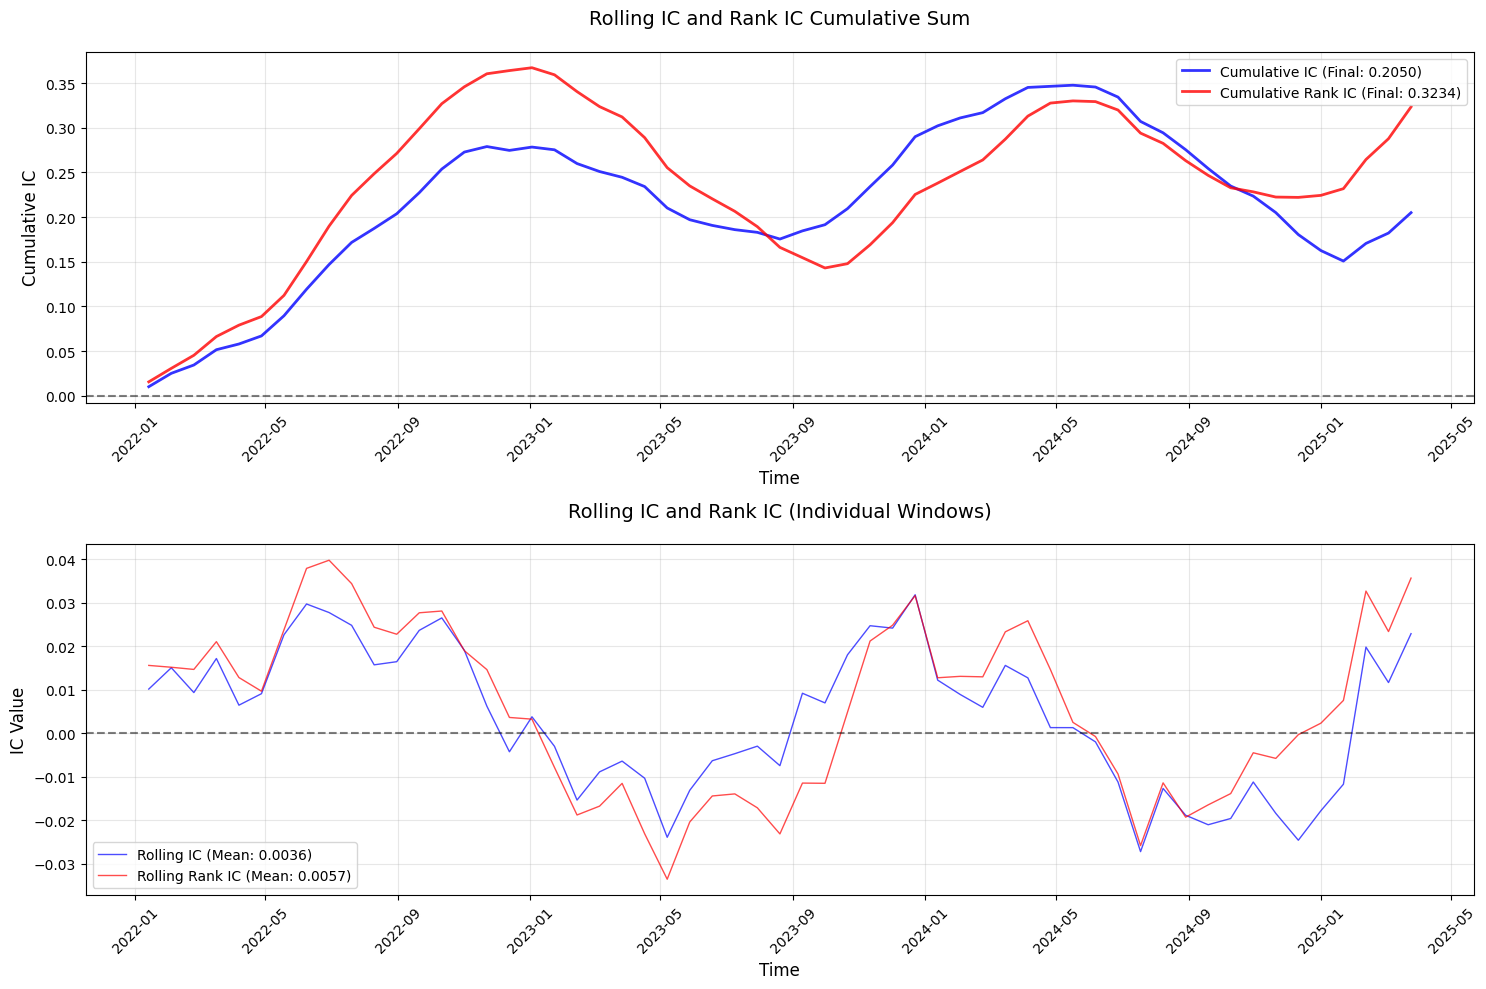

✅ 已显示 4 个图片
----------------------------------------


In [12]:
evaluator.set_factor(
    factor_func=factor_minute_count,
    factor_name='factor_minute_count'
)
result1 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子2: 量岭分钟收益率

In [13]:
def factor_ridge_return(df, lookback=96):
    """量岭时点的分钟收益率（滚动平均）"""
    df = _classify_volume_states(df)
    
    # 计算分钟收益率
    returns = df['close'] / df['open'] - 1
    
    # 仅在量岭时点取值
    ridge_returns = returns.where(df['is_ridge'], np.nan)
    
    # 滚动平均
    return ridge_returns.rolling(lookback, min_periods=24).mean().fillna(0)

因子测试框架 - 量岭分钟数因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.020432
   Rank_IC (Spearman): -0.023088
📊 信息比率:
   IR: -1.028385
   有效分组数: 2
📊 因子分布:
📋 数据概况:
   数据长度: 132183
   因子列: factor_ridge_return
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


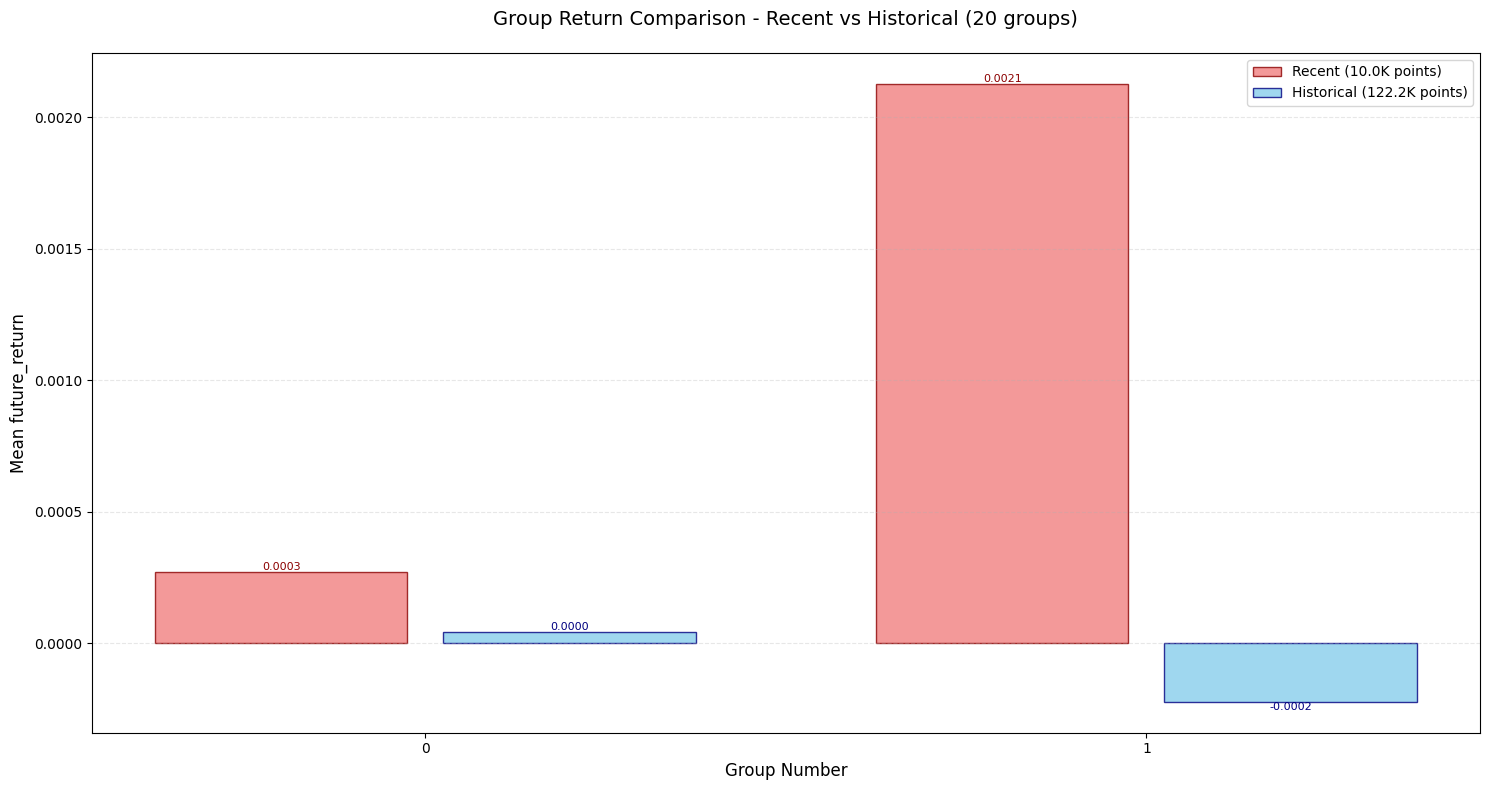

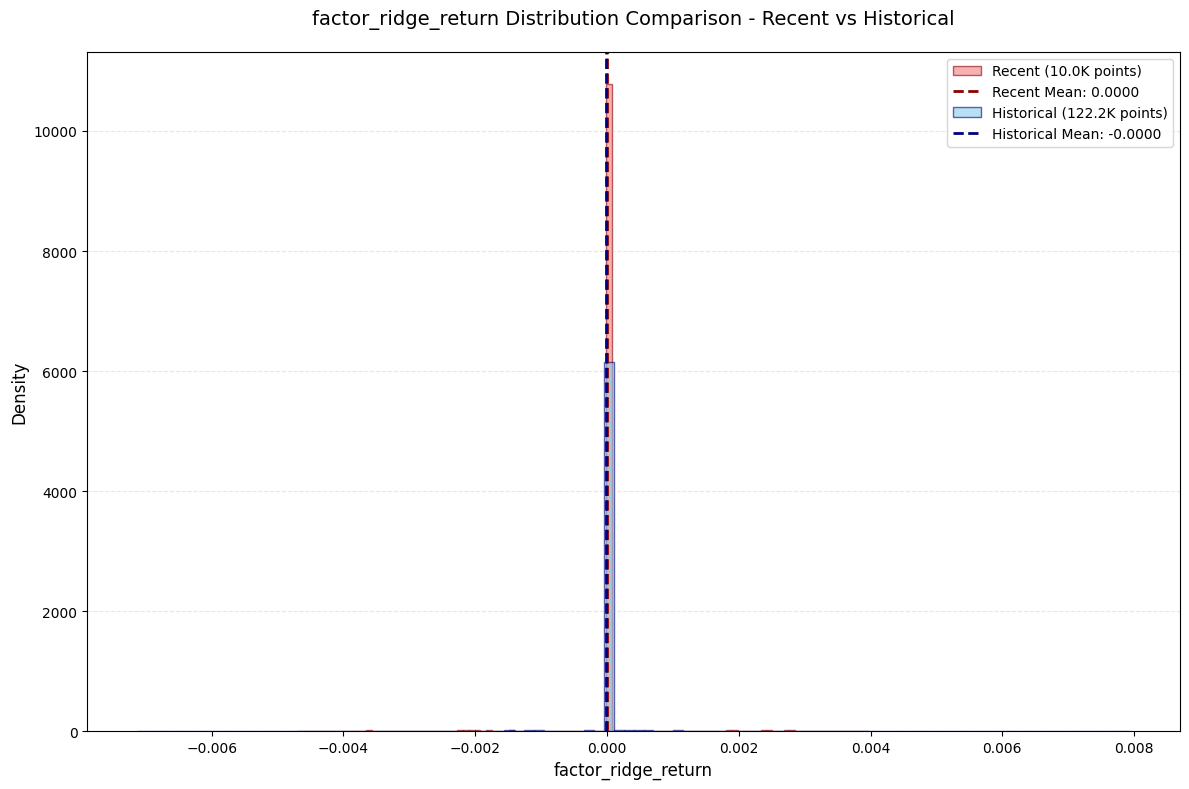

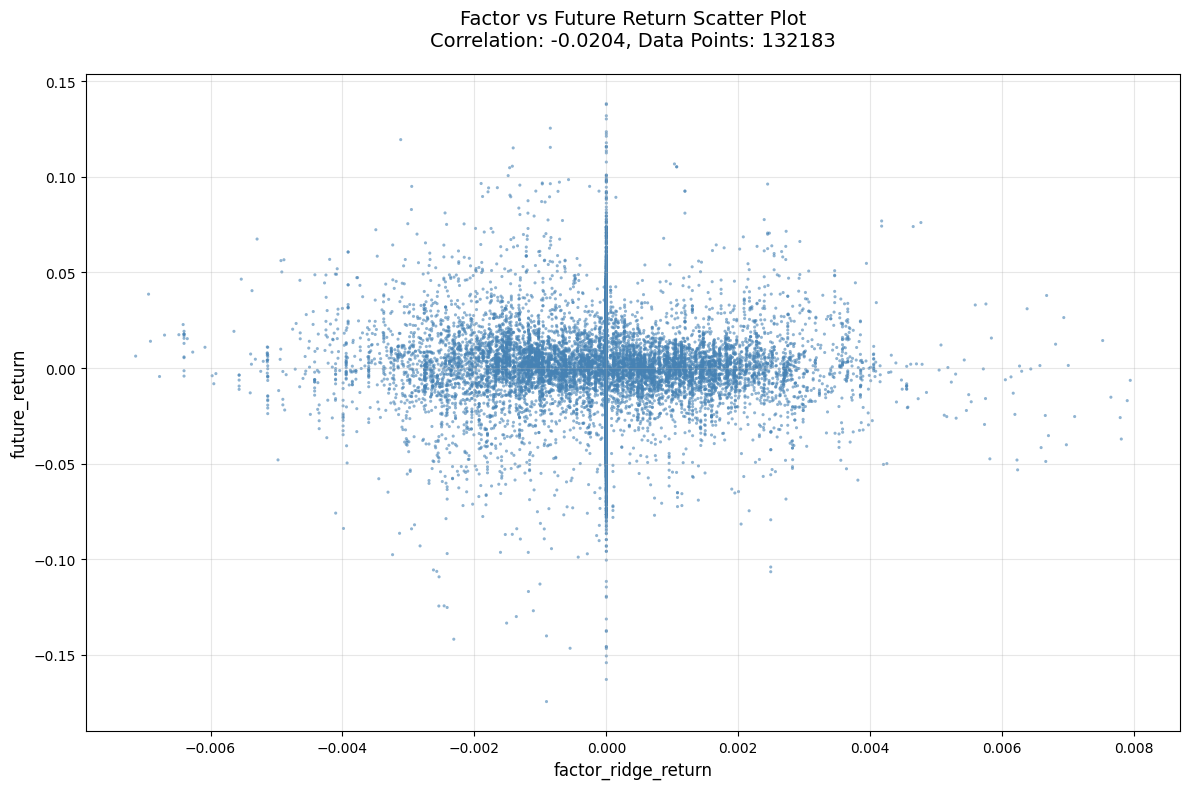

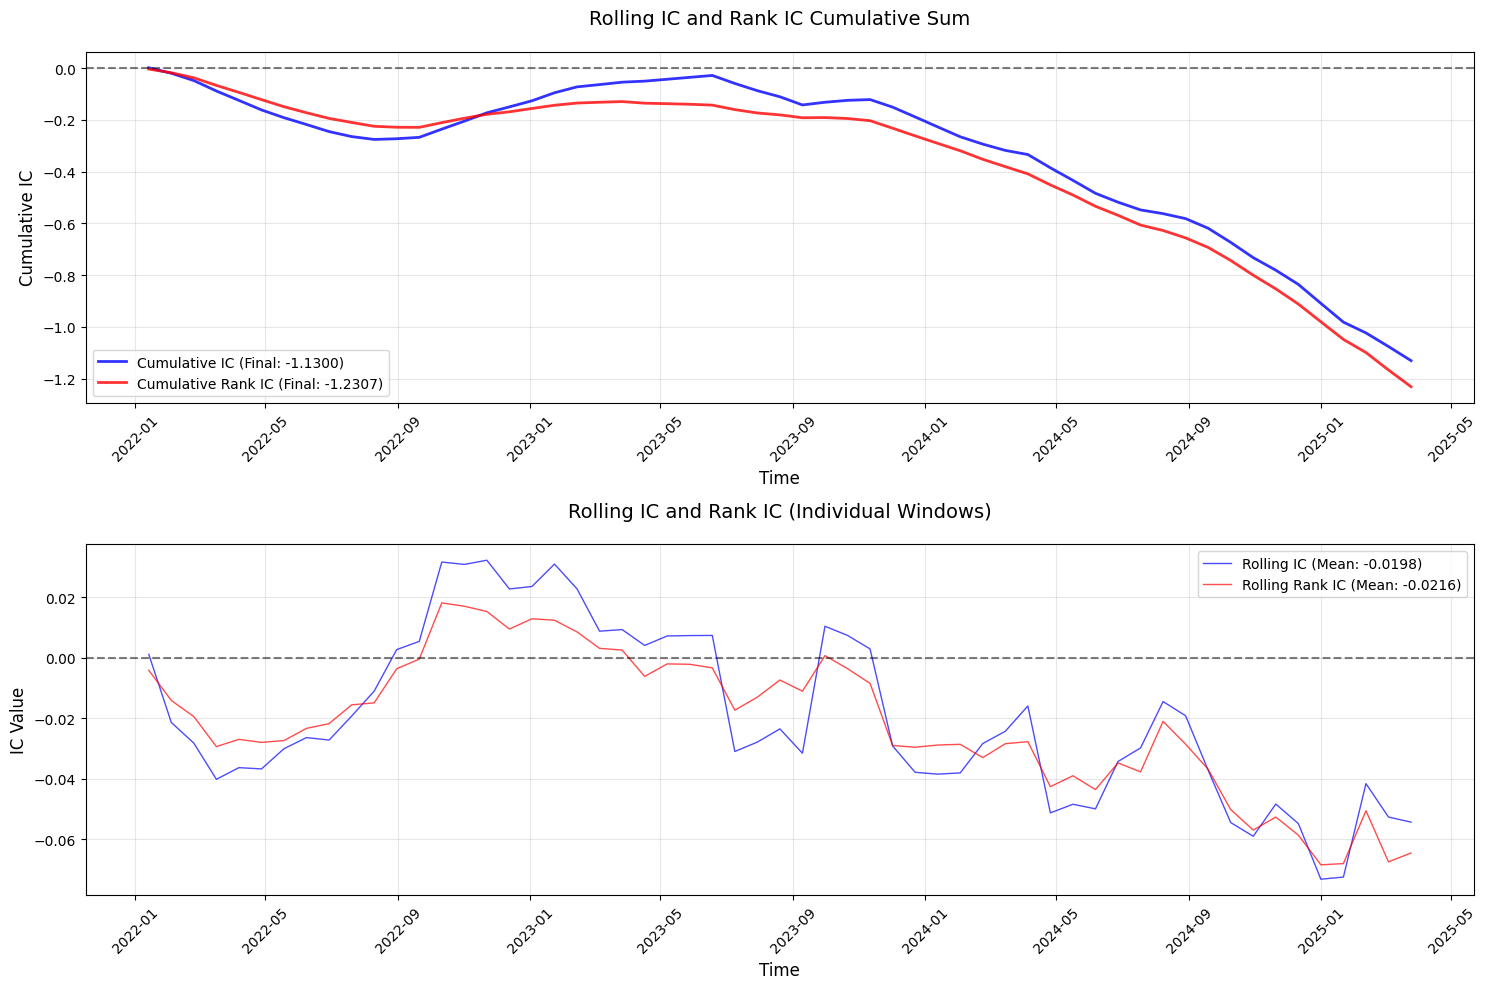

✅ 已显示 4 个图片
----------------------------------------


In [14]:
evaluator.set_factor(
    factor_func=factor_ridge_return,
    factor_name='factor_ridge_return'
)
result2 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子3: 相对加权价（量岭、量谷）

In [15]:
def factor_relative_vwap(df, state='ridge', lookback=96):
    """
    特定状态下相对VWAP（成交量加权平均价）
    
    state: 'ridge' - 量岭, 'valley' - 量谷
    """
    df = df.copy()
    state_col = f'is_{state}'
    
    # 计算VWAP
    df['vwap'] = df['turnover'] / df['volume']
    
    # 计算相对价格：(close - vwap)/vwap
    rel_price = (df['close'] - df['vwap']) / df['vwap']
    
    # 仅在特定状态时取值
    state_rel_price = rel_price.where(df[state_col], np.nan)
    
    # 滚动平均
    return state_rel_price.rolling(lookback, min_periods=24).mean().fillna(0)

因子测试框架 - 量岭分钟收益因子

In [ ]:
# evaluator.set_factor(
#     factor_func=factor_relative_vwap,
#     factor_name='factor_relative_vwap'
# )
# result3 = evaluator.run_full_evaluation(run_stationarity_test=False)

ValueError: 因子函数执行失败: 'is_ridge'

# 因子4: 加权价格分位点（量峰、量谷）

In [17]:
def factor_vwap_quantile(df, state='peak', daily_window=96):
    """
    特定状态下VWAP在当日分位点
    
    state: 'peak' - 量峰, 'valley' - 量谷
    daily_window: 每日K线数量（96根=24小时）
    """
    df = df.copy()
    state_col = f'is_{state}'
    
    # 计算VWAP
    df['vwap'] = df['turnover'] / df['volume']
    
    # 按日分组计算分位点
    def calc_daily_quantile(group):
        # 仅对特定状态计算
        state_group = group[group[state_col]]
        if len(state_group) < 5:  # 至少5个点才计算
            return pd.Series(np.nan, index=group.index)
        
        # 计算分位点
        vwap_vals = state_group['vwap'].values
        quantiles = [np.sum(vwap_vals < x) / len(vwap_vals) for x in group['vwap']]
        return pd.Series(quantiles, index=group.index)
    
    # 应用分组计算
    return df.groupby(pd.Grouper(freq='D')).apply(calc_daily_quantile).fillna(0)

因子测试框架 - 量谷相对VWAP因子

In [18]:
evaluator.set_factor(
    factor_func=factor_vwap_quantile,
    factor_name='factor_vwap_quantile'
)
result4 = evaluator.run_full_evaluation(run_stationarity_test=False)

ValueError: 因子函数执行失败: 'is_peak'

# 因子5: 时间间隔特征（量峰、量岭）

In [19]:
def factor_time_interval(df, state='peak', stat='mean'):
    """
    特定状态出现的时间间隔统计特征
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    stat: 'mean' - 均值, 'std' - 标准差
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 标记状态发生时间
    state_occurrences = df[df[state_col]].index
    
    # 计算时间间隔（分钟）
    intervals = []
    if len(state_occurrences) > 1:
        time_diffs = np.diff(state_occurrences)
        intervals = [td.total_seconds() / 60 for td in time_diffs]
    
    # 创建结果序列
    result = pd.Series(np.nan, index=df.index)
    
    if intervals:
        # 计算统计特征
        if stat == 'mean':
            value = np.mean(intervals)
        elif stat == 'std':
            value = np.std(intervals)
        else:
            value = np.nan
        
        # 仅在有状态发生时赋值
        result.loc[state_occurrences] = value
    
    return result.fillna(method='ffill').fillna(0)

因子测试框架 - 量峰价格分位因子

In [20]:
evaluator.set_factor(
    factor_func=factor_time_interval,
    factor_name='factor_time_interval'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)

ValueError: 因子函数执行失败: 'numpy.timedelta64' object has no attribute 'total_seconds'

# 因子6：成交额比值（量峰、量岭）

In [21]:
def factor_turnover_ratio(df, state='peak', lookback=96):
    """
    特定状态下成交额与同时段平均值的比值
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 计算同时段平均成交额
    time_avg_turnover = df.groupby('time_group')['turnover'].transform(
        lambda x: x.rolling(lookback, min_periods=24).mean())
    
    # 计算比值
    ratio = df['turnover'] / time_avg_turnover
    
    # 仅在特定状态时取值
    state_ratio = ratio.where(df[state_col], np.nan)
    
    return state_ratio.fillna(method='ffill').fillna(1)

因子测试框架 - 量峰价格分位因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.005735
   Rank_IC (Spearman): 0.012621
📊 信息比率:
   IR: 0.057983
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 132183
   因子列: factor_turnover_ratio
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


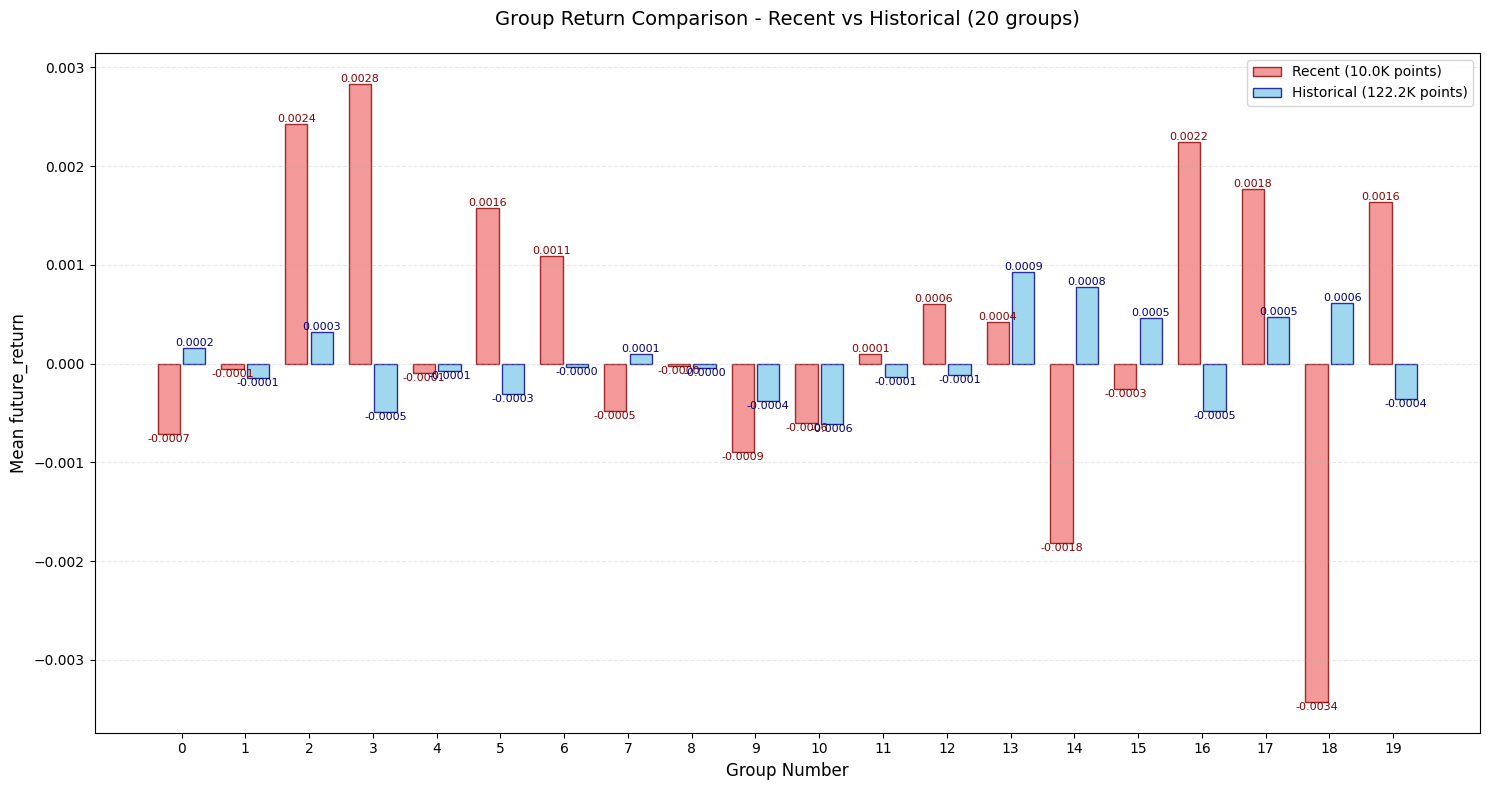

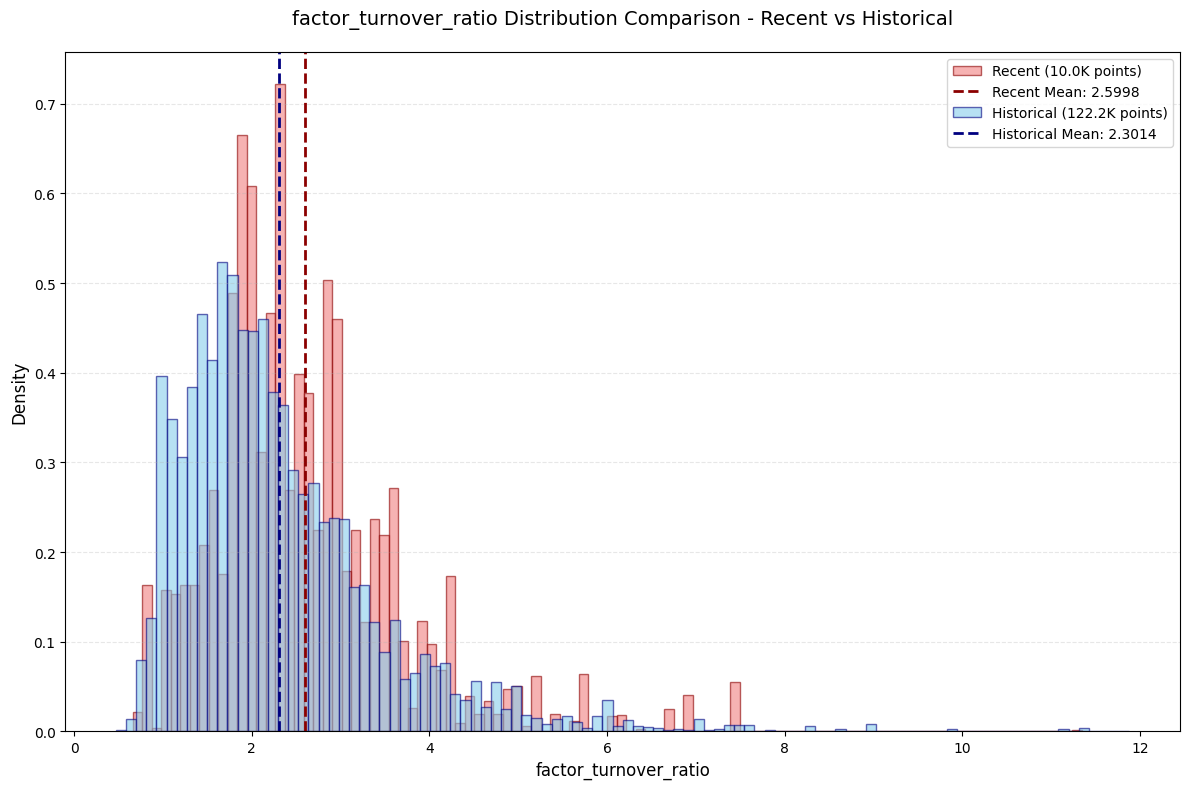

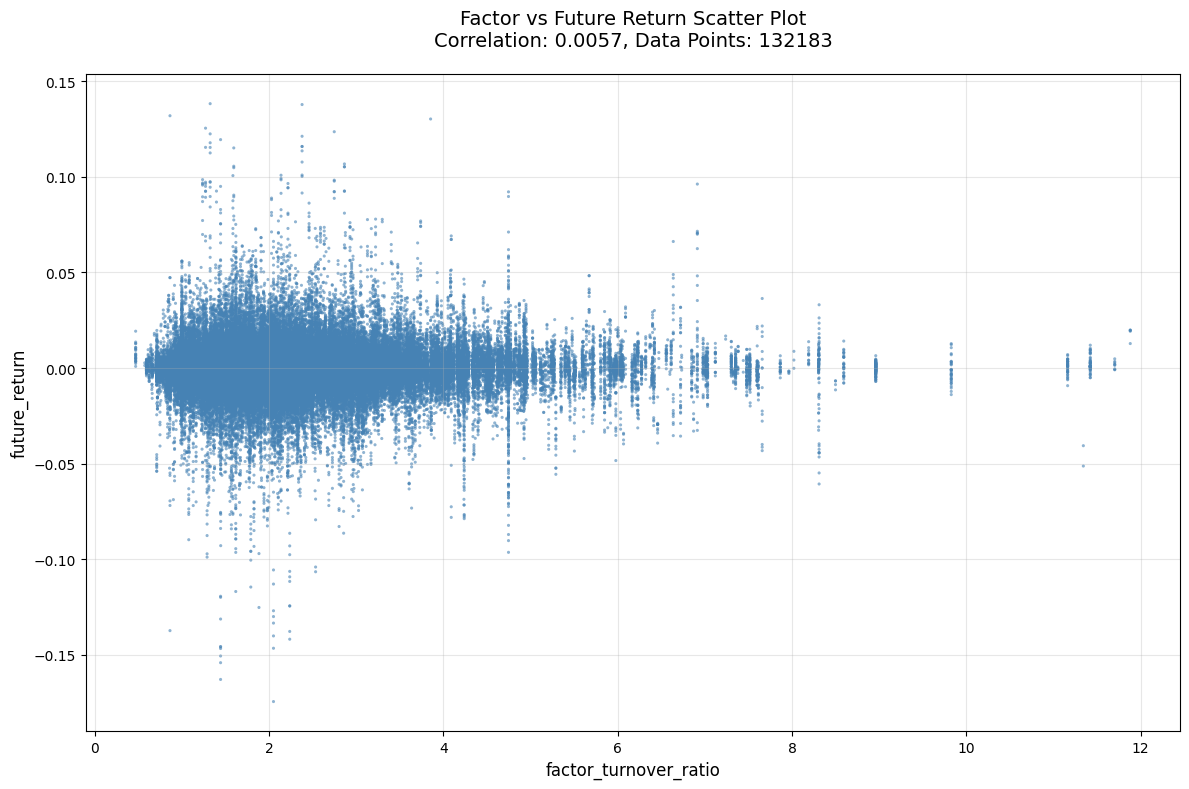

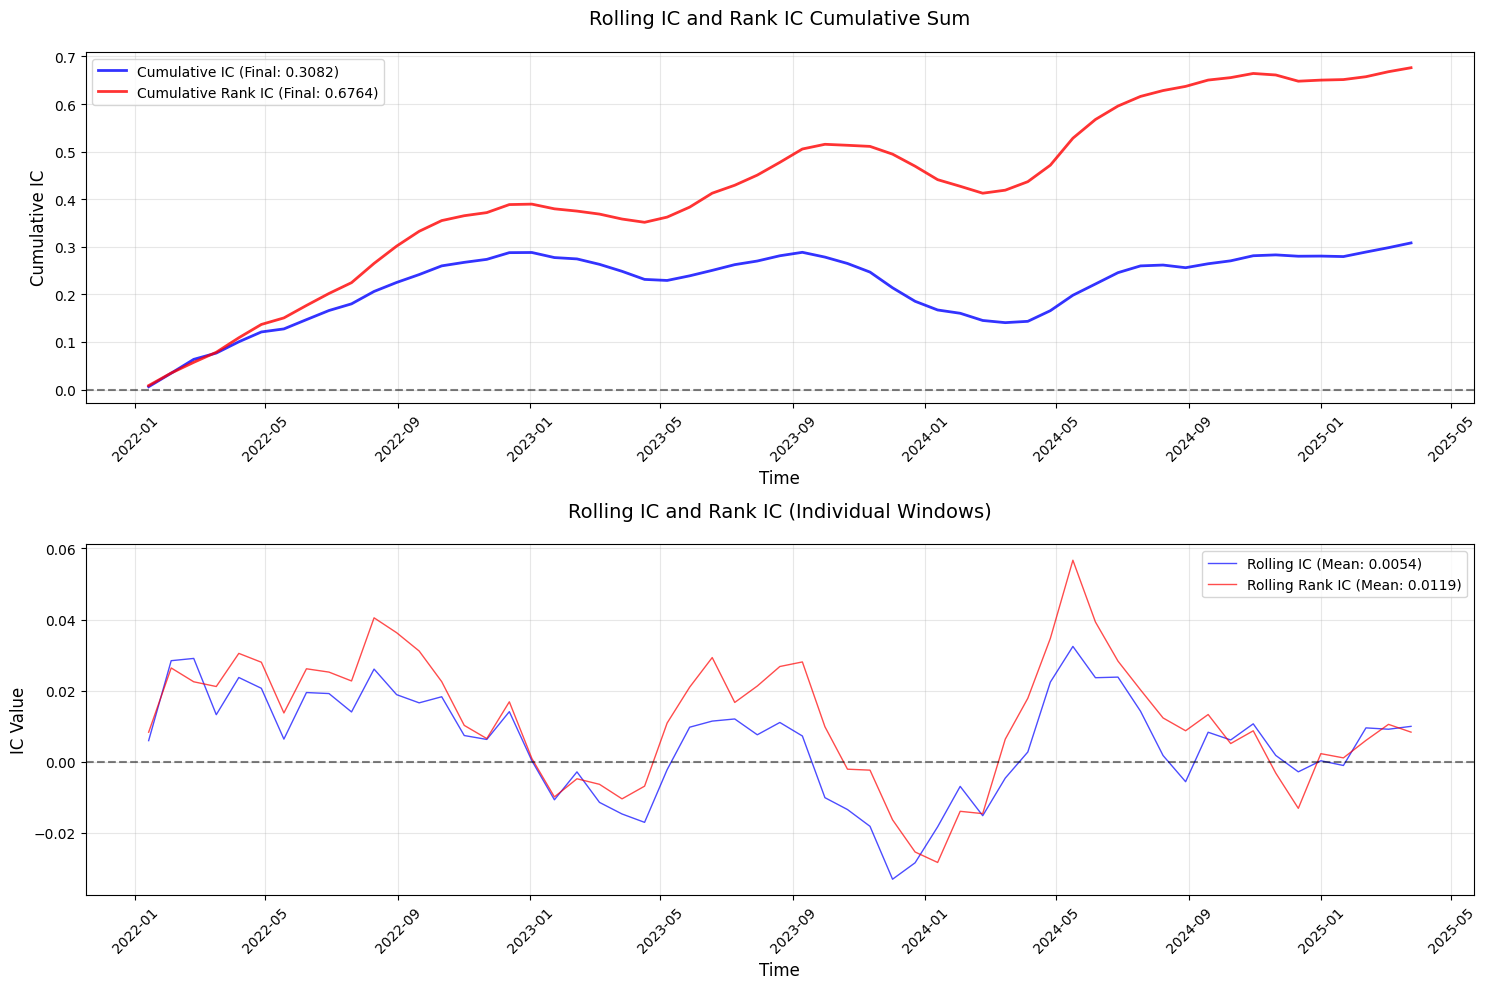

✅ 已显示 4 个图片
----------------------------------------


In [22]:
evaluator.set_factor(
    factor_func=factor_turnover_ratio,
    factor_name='factor_turnover_ratio'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子7：成交额跟随比例（量峰、量岭）

In [23]:
def factor_turnover_follow_ratio(df, state='peak', lookback=96):
    """
    特定状态下成交额跟随比例
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 计算下一根K线成交额变化
    next_turnover = df['turnover'].shift(-1)
    turnover_change = next_turnover / df['turnover'] - 1
    
    # 仅在特定状态时取值
    state_change = turnover_change.where(df[state_col], np.nan)
    
    # 滚动平均跟随比例
    return state_change.rolling(lookback, min_periods=24).mean().fillna(0)

因子测试框架 - 量峰价格分位因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): nan
   Rank_IC (Spearman): nan
📊 信息比率:
   IR: nan
   有效分组数: 0
📊 因子分布:
📋 数据概况:
   数据长度: 132183
   因子列: factor_turnover_follow_ratio
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


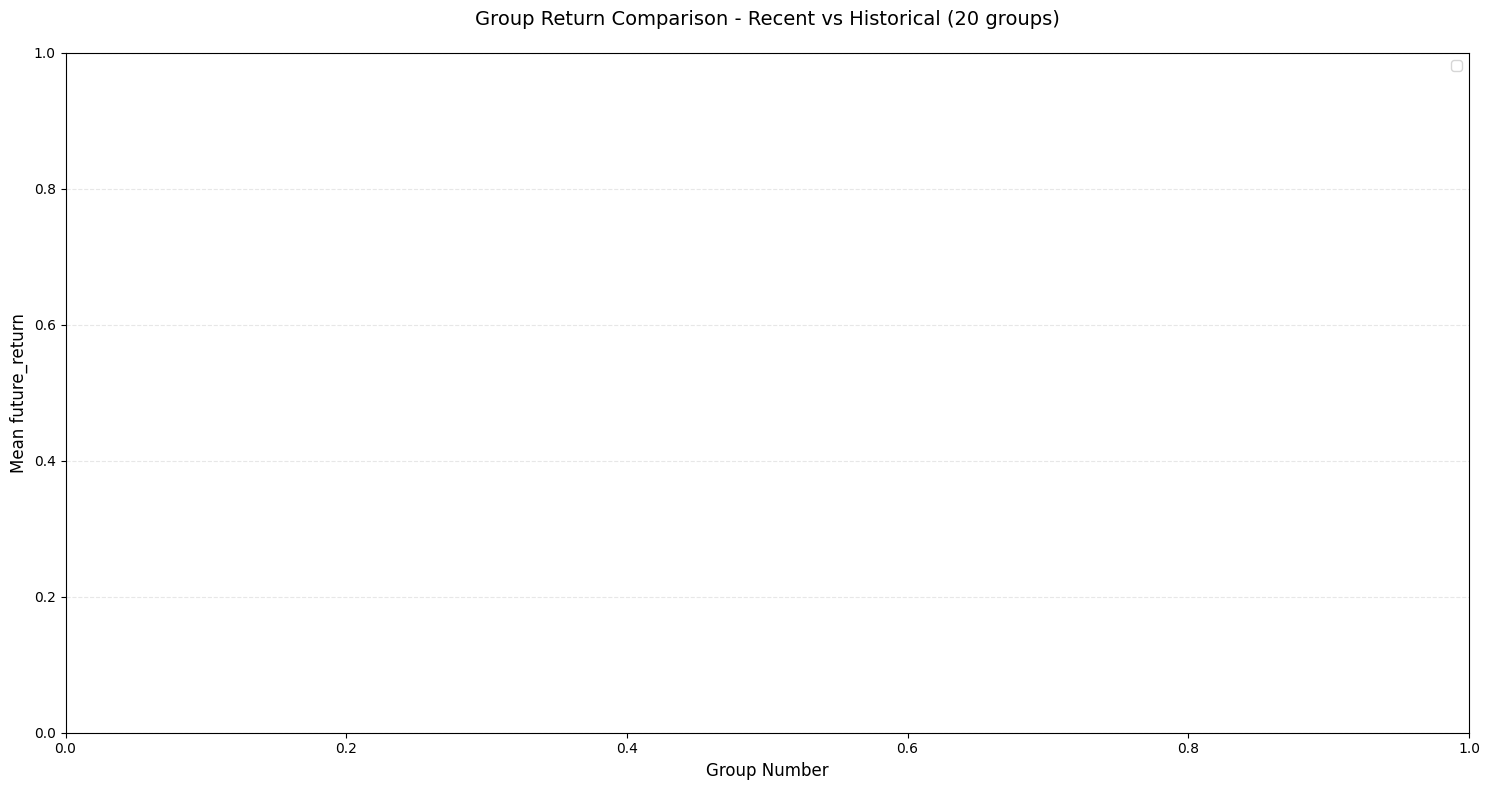

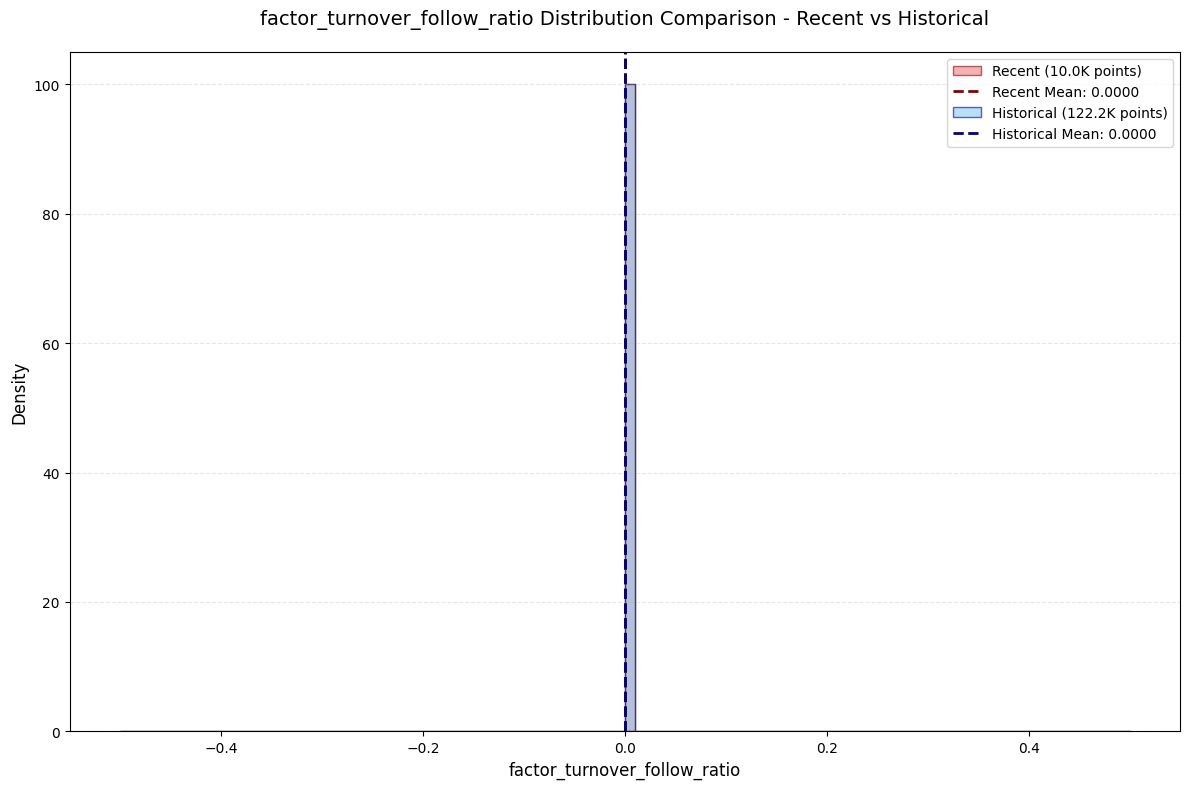

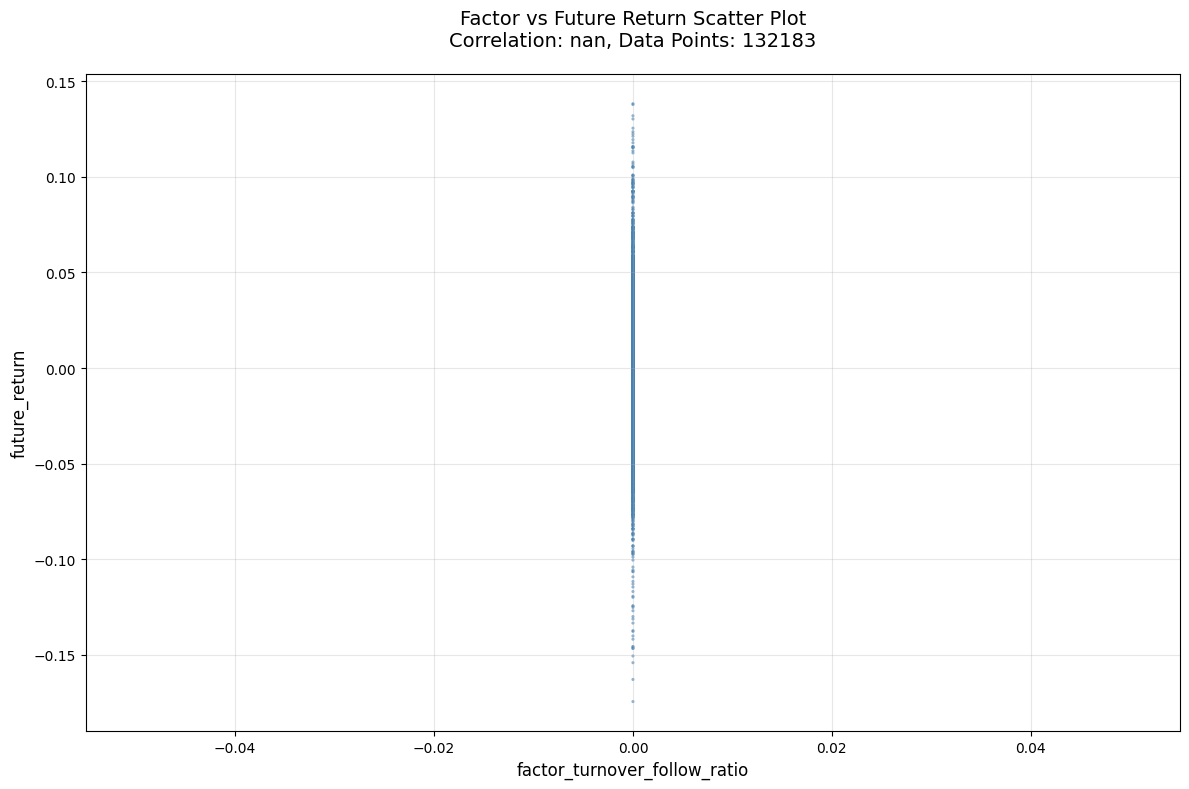

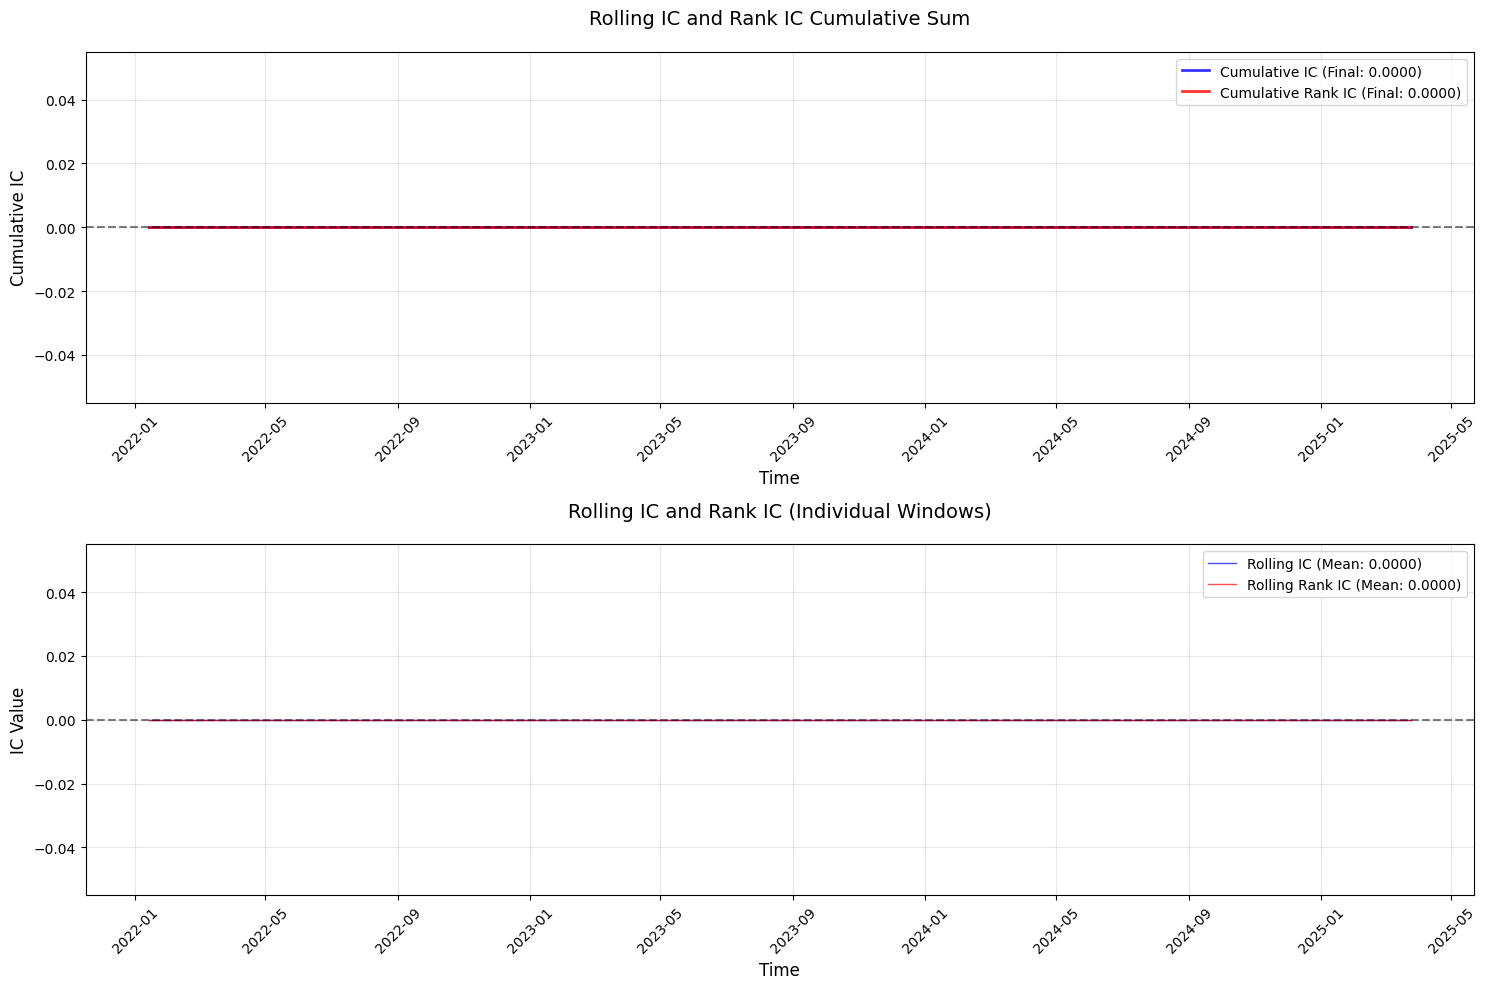

✅ 已显示 4 个图片
----------------------------------------


In [24]:
evaluator.set_factor(
    factor_func=factor_turnover_follow_ratio,
    factor_name='factor_turnover_follow_ratio'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子8：成交额敏感度（量峰、量岭）

In [25]:
def factor_turnover_sensitivity(df, state='peak', lookback=24):
    """
    特定状态下成交额对价格变动的敏感度
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 计算价格变动
    price_change = df['close'].pct_change()
    
    # 仅在特定状态时计算
    valid_idx = df[df[state_col]].index
    
    # 存储敏感度结果
    sensitivities = pd.Series(np.nan, index=df.index)
    
    for idx in valid_idx:
        # 获取回看窗口数据
        start_idx = max(0, df.index.get_loc(idx) - lookback)
        window_df = df.iloc[start_idx:df.index.get_loc(idx)+1]
        
        if len(window_df) < 5:  # 最小数据点要求
            continue
        
        # 计算成交额与价格变动的相关系数
        corr = window_df['turnover'].corr(window_df['close'].pct_change())
        sensitivities.loc[idx] = corr if not np.isnan(corr) else 0
    
    return sensitivities.fillna(method='ffill').fillna(0)

因子测试框架 - 量峰价格分位因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.005799
   Rank_IC (Spearman): -0.021946
📊 信息比率:
   IR: 0.111467
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 132183
   因子列: factor_turnover_sensitivity
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


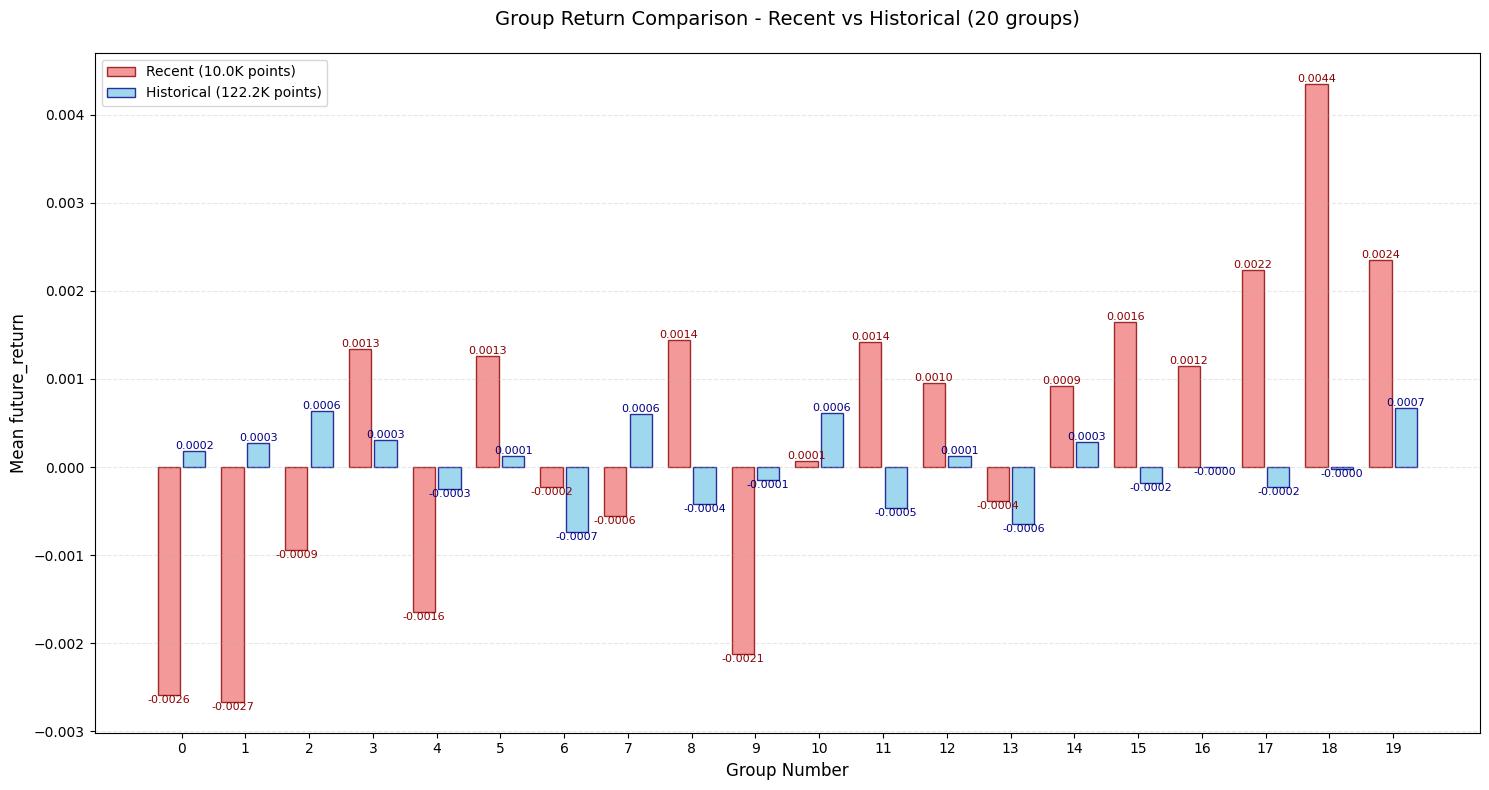

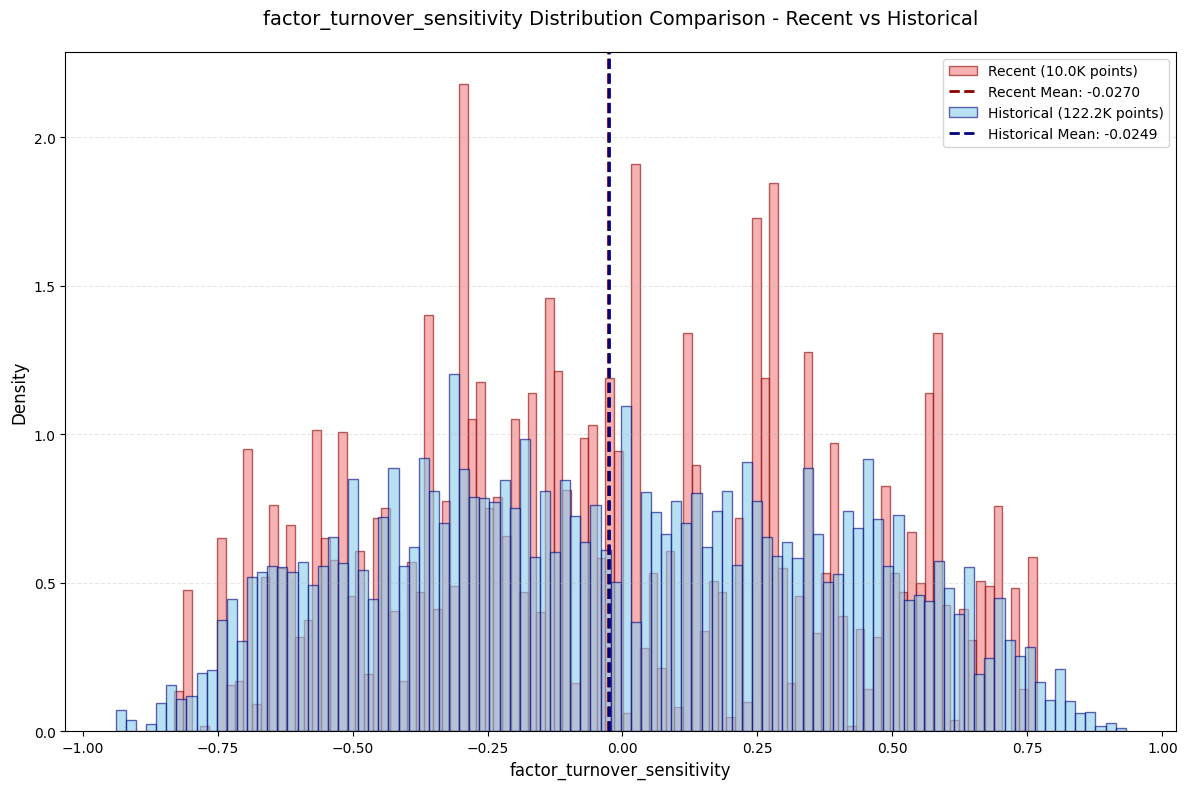

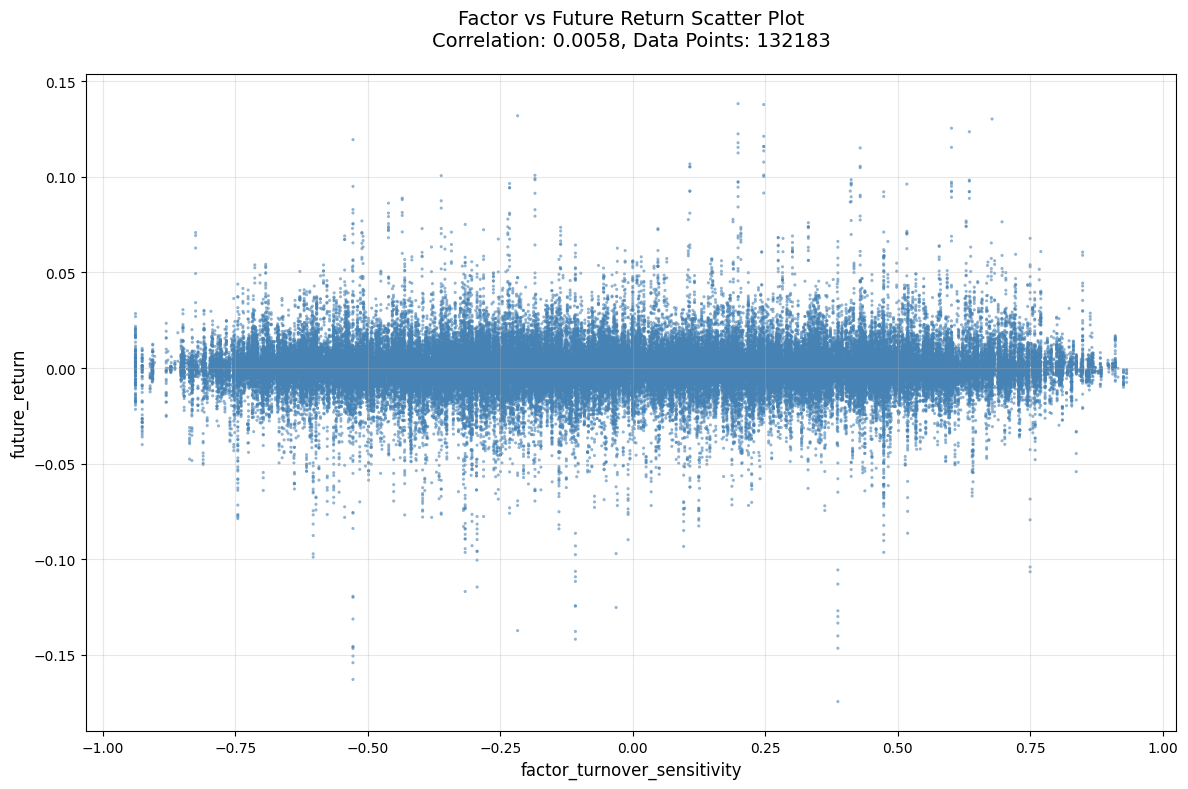

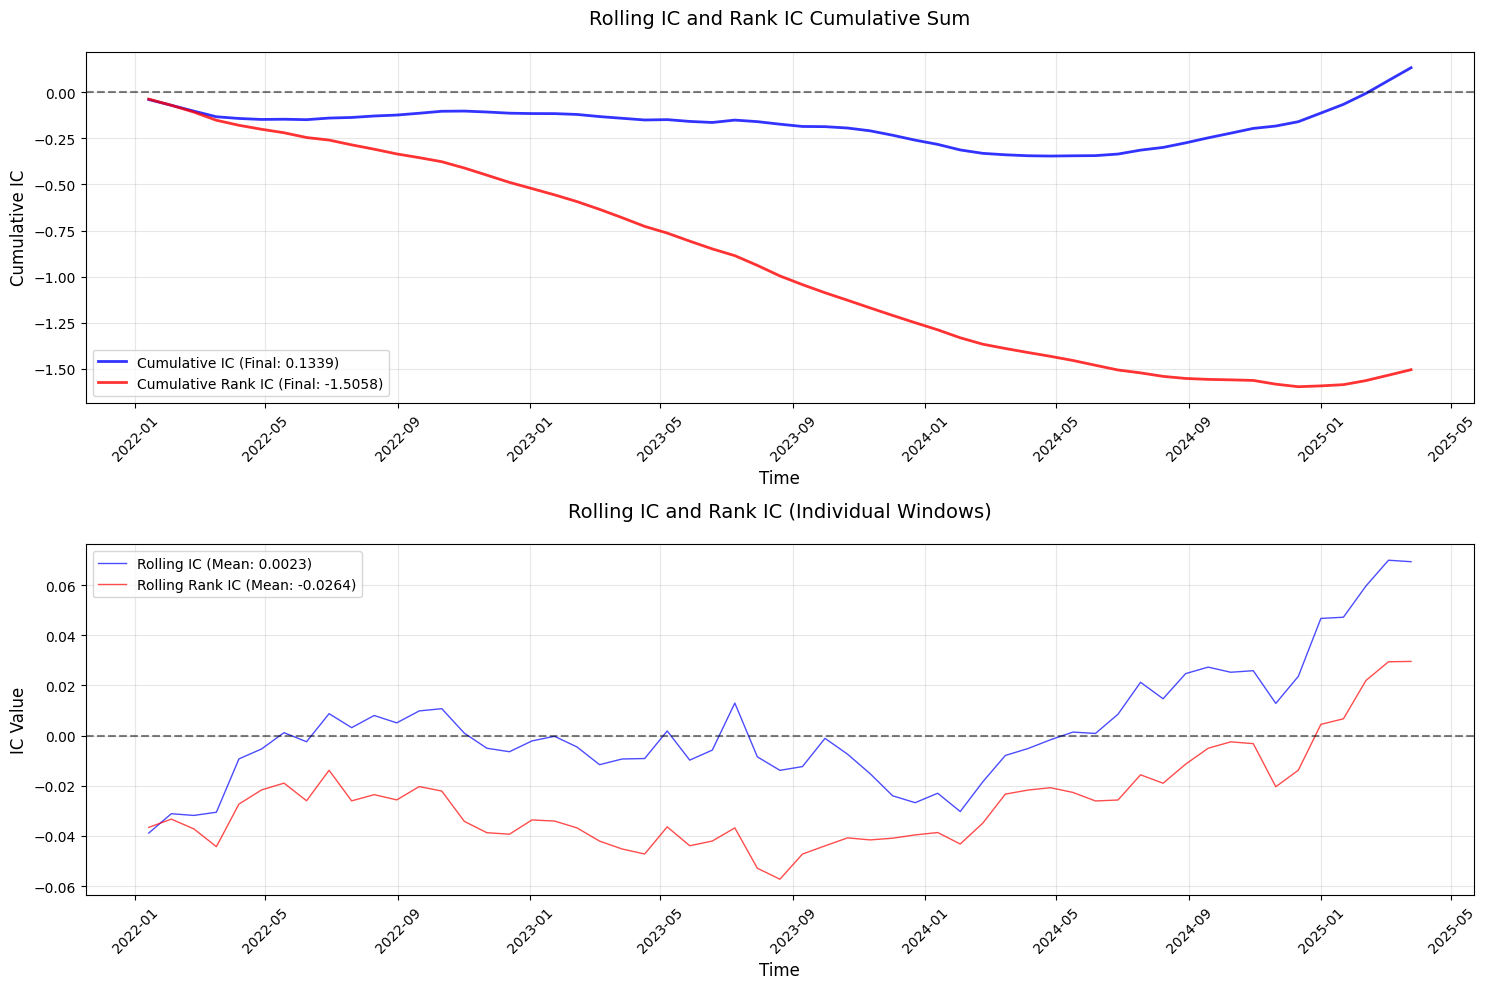

✅ 已显示 4 个图片
----------------------------------------


In [26]:
evaluator.set_factor(
    factor_func=factor_turnover_sensitivity,
    factor_name='factor_turnover_sensitivity'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)

# 因子9：成交额相关性（量峰、量岭）

In [27]:
def factor_turnover_correlation(df, state='peak', lookback=96):
    """
    特定状态下成交额与taker_buy_volume的相关性
    
    state: 'peak' - 量峰, 'ridge' - 量岭
    """
    df = _classify_volume_states(df)
    state_col = f'is_{state}'
    
    # 仅在特定状态时计算
    state_df = df[df[state_col]]
    
    # 滚动相关性
    corr = state_df['turnover'].rolling(lookback).corr(state_df['taker_buy_volume'])
    
    # 对齐到原始索引
    return df.index.map(corr).fillna(method='ffill').fillna(0)

因子测试框架 - 量峰价格分位因子

In [28]:
evaluator.set_factor(
    factor_func=factor_turnover_correlation,
    factor_name='factor_turnover_correlation'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)

ValueError: 因子函数执行失败: Index.fillna() got an unexpected keyword argument 'method'

因子测试框架 - 量峰价格分位因子


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.007010
   Rank_IC (Spearman): -0.008212
📊 信息比率:
   IR: 0.291910
   有效分组数: 7
📊 因子分布:
📋 数据概况:
   数据长度: 131915
   因子列: peak_price_quantile
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


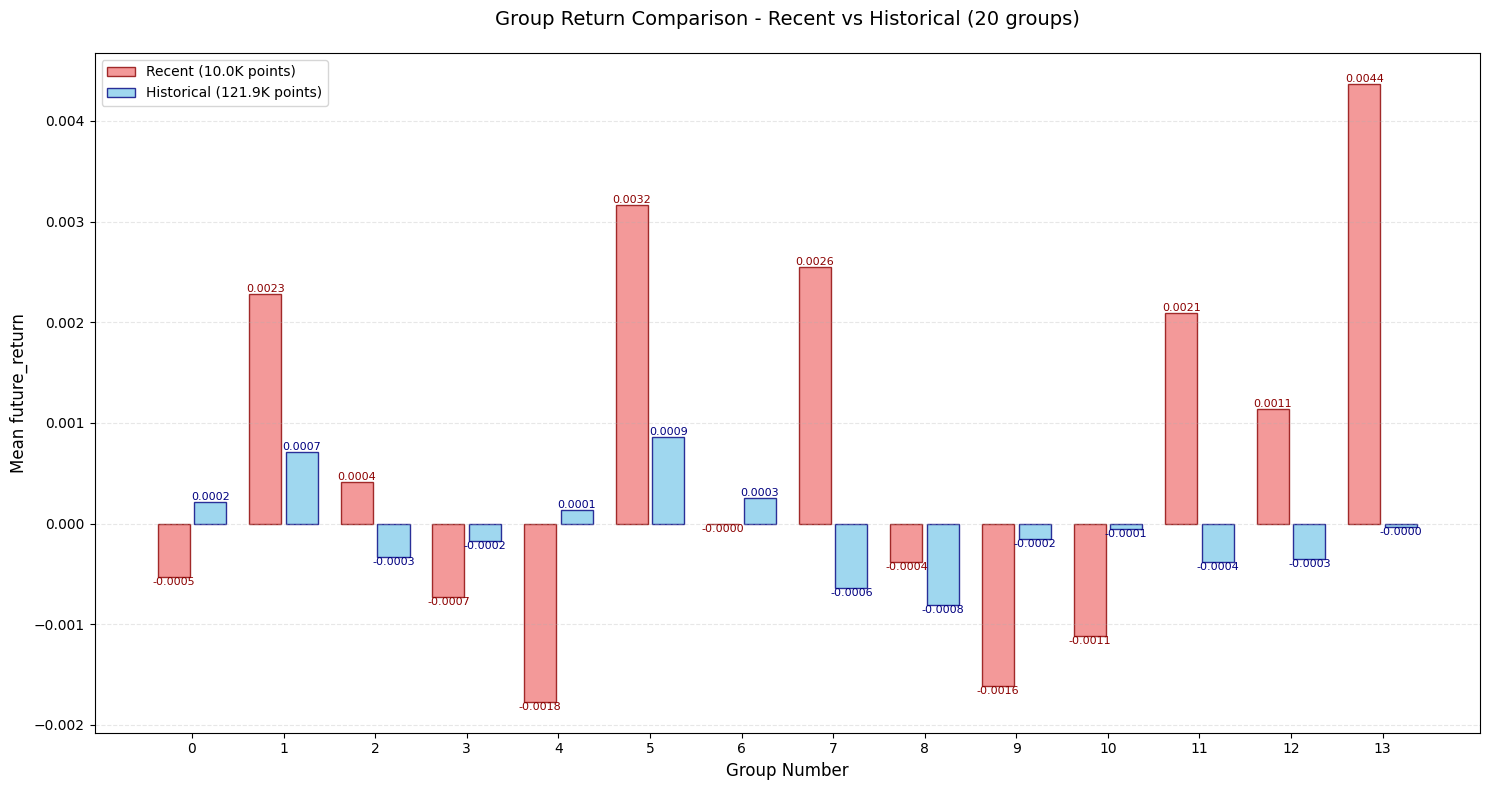

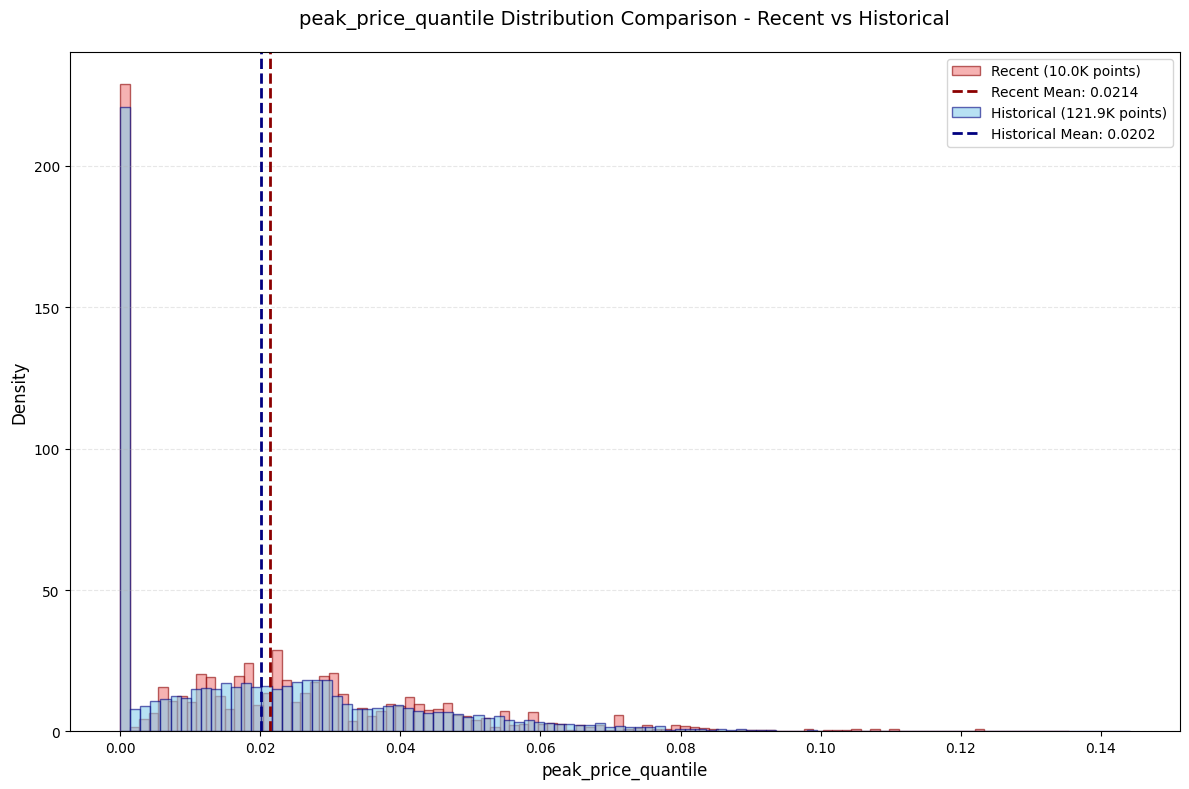

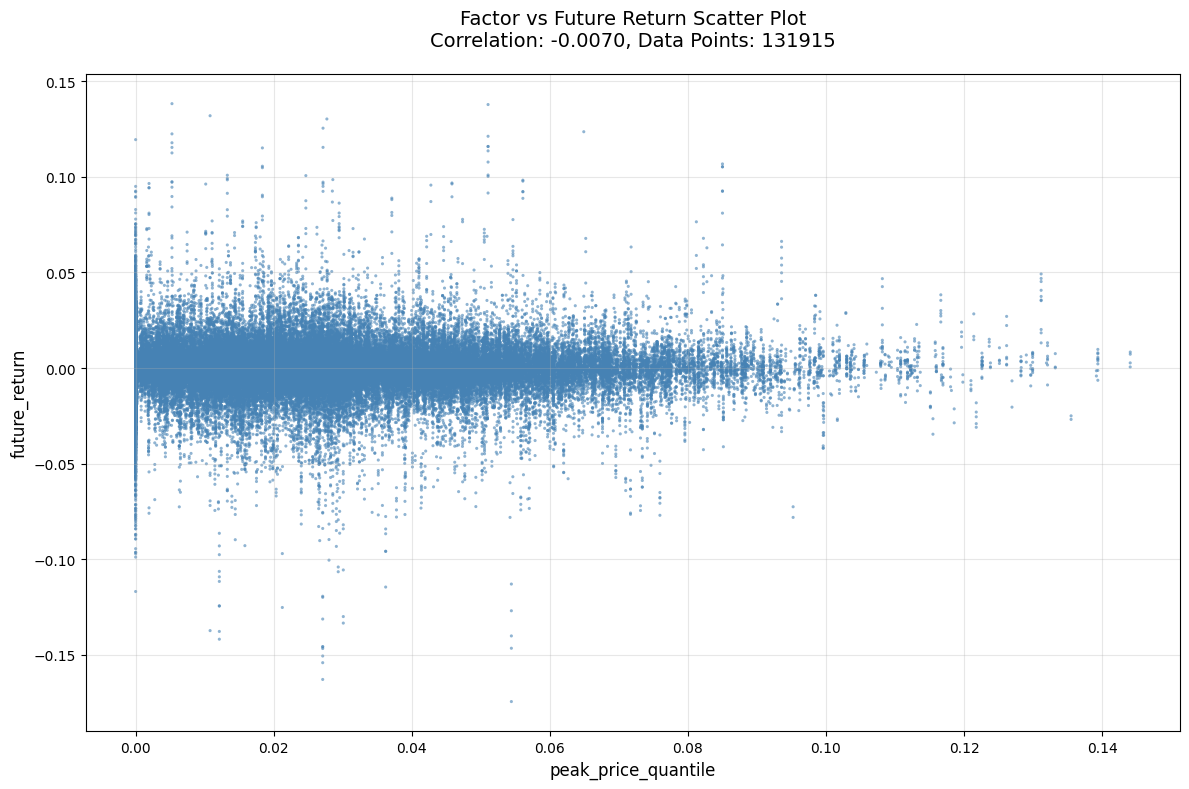

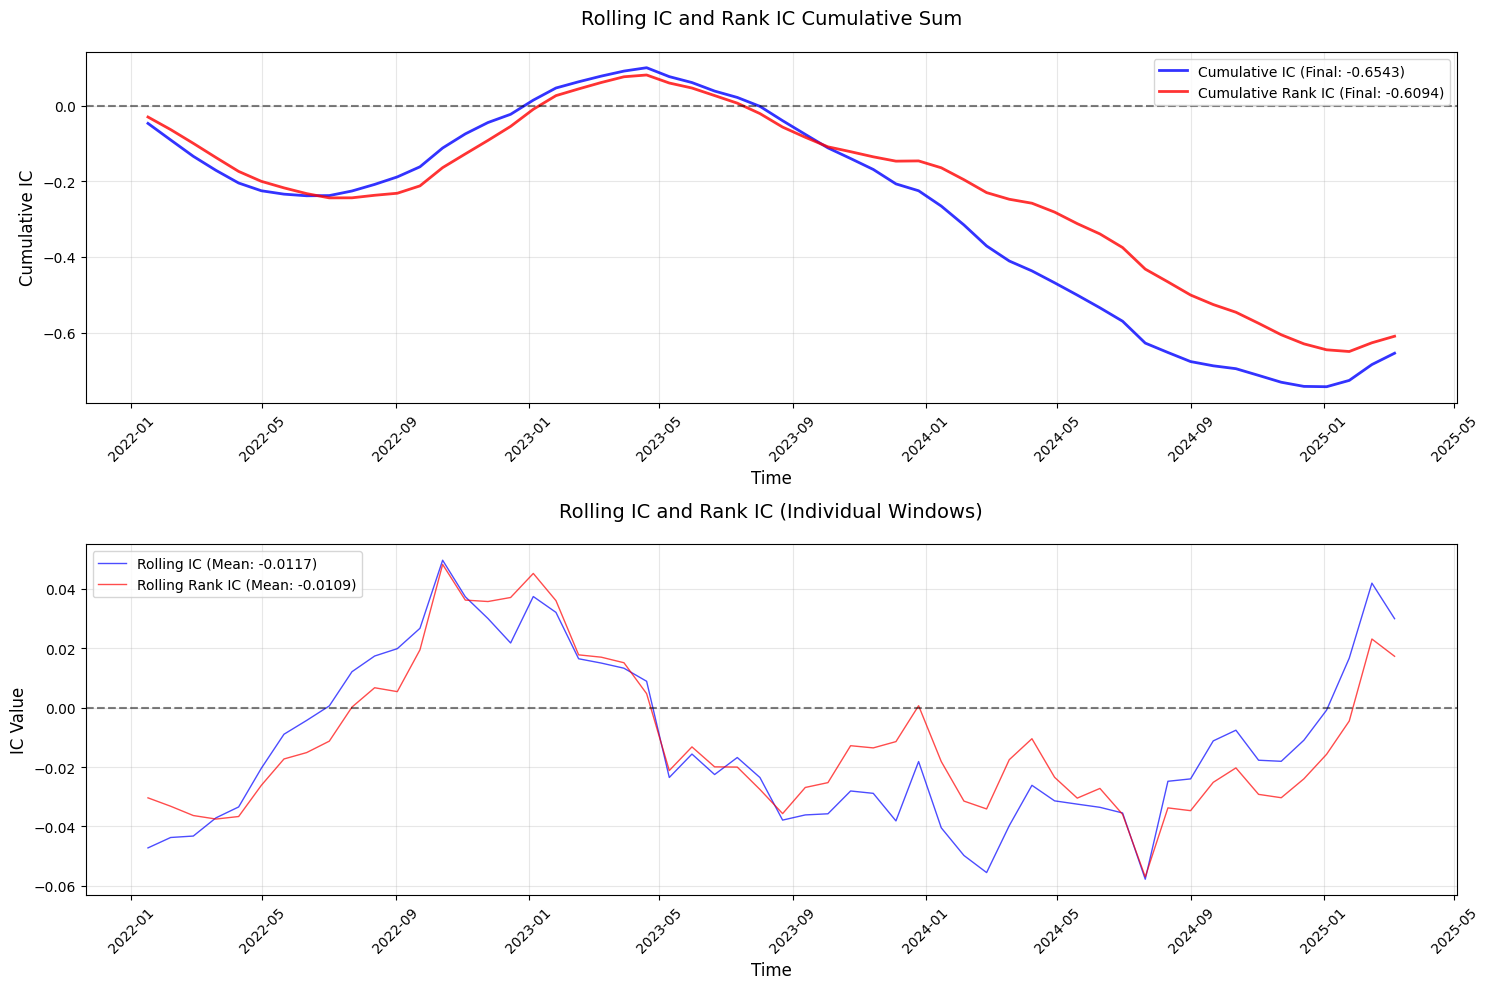

✅ 已显示 4 个图片
----------------------------------------


In [ ]:
evaluator.set_factor(
    factor_func=factor_time_interval,
    factor_name='factor_time_interval'
)
result5 = evaluator.run_full_evaluation(run_stationarity_test=False)